In [4]:
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
#from monai.transforms import Spacing
import re
import os
from tqdm import tqdm
#from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance, compute_meandice
import h5py
import scipy as sp
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
#import seaborn as sns
#from monai.networks.utils import to_onehot

In [5]:
%python –version

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [7]:
import scipy
scipy.__version__

'1.9.3'

In [3]:
#make list of data dictionaries
train_images_path = Path('../TBI/GT_filtered+raw/') #raw path images
train_images_paths = list(train_images_path.glob('*.tif'))#get images
train_images = sorted([x.as_posix() for x in train_images_paths])#sort
train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)

In [4]:
print(len(data_dicts))

42


In [5]:
print(train_images)

['../TBI/GT_filtered+raw/Result_of_XYZres114_0001.tif', '../TBI/GT_filtered+raw/XYZres008.tif', '../TBI/GT_filtered+raw/XYZres013_0001.tif', '../TBI/GT_filtered+raw/XYZres018_0001.tif', '../TBI/GT_filtered+raw/XYZres025.tif', '../TBI/GT_filtered+raw/XYZres032.tif', '../TBI/GT_filtered+raw/XYZres037.tif', '../TBI/GT_filtered+raw/XYZres042_0001.tif', '../TBI/GT_filtered+raw/XYZres050.tif', '../TBI/GT_filtered+raw/XYZres110.tif', '../TBI/GT_filtered+raw/XYZres114_0001.tif', '../TBI/GT_filtered+raw/XYZres115.tif', '../TBI/GT_filtered+raw/XYZres120_0001.tif', '../TBI/GT_filtered+raw/XYZres128.tif', '../TBI/GT_filtered+raw/XYZres131_0001.tif', '../TBI/GT_filtered+raw/XYZres147.tif', '../TBI/GT_filtered+raw/XYZres149_0001.tif', '../TBI/GT_filtered+raw/XYZres153_0001.tif', '../TBI/GT_filtered+raw/XYZres157.tif', '../TBI/GT_filtered+raw/XYZres160.tif', '../TBI/GT_filtered+raw/XYZres163_0001.tif', '../TBI/GT_filtered+raw/XYZres171.tif', '../TBI/GT_filtered+raw/XYZres177_0001.tif', '../TBI/GT_fil

In [6]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:15]
print(len(train))
#log_param('train_set',' '.join(train))
val = mouse_ids_present[15:-6]
print(len(val))
#log_param('val_set',' '.join(val))
test = mouse_ids_present[-6:]
print(len(test))

15
4
6


In [7]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    test_files.append(k)

In [8]:
train_file = [x['label'] for x in train_files]
#print(len(train_file))
#print(train_file)
val_file = [x['label'] for x in val_files]
#print(len(val_file))
#print(val_file)
test_file = [x['label'] for x in test_files]
print(len(test_file))
print(test_file)

9
['../TBI/GT_filtered+raw/XYZres013_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres95_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres032_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres025_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres114_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres008_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres115_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres204_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres214_0001_Simple Segmentation_sub1.tiff']


In [19]:
label = 2
min_prob = 0.5
max_var = 0.2

In [20]:
#np.unique(io.imread(x))

# UNETR Ensembale

In [21]:
unetrEnsemble = pd.DataFrame()

In [22]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','matt_preds',x)))
        _std = pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_std.npy',re.sub('../TBI/GT_filtered\+raw','matt_preds',x)))
    elif os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','james_preds',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','james_preds',x)))
        _std = np.load(re.sub('_Simple Segmentation_sub1.tiff','_std.npy',re.sub('../TBI/GT_filtered\+raw','james_preds',x)))
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob) * (_std[1,:,:,:] < max_var)] = 1
    seg[(_mean[2,:,:,:] > min_prob) * (_std[2,:,:,:] < max_var)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    #break
    #print(compute_hausdorff_distance(truth,seg,percentile=95))
    #print(compute_average_surface_distance(truth,seg))
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetrEnsemble = unetrEnsemble.append(new_row,ignore_index=True)
print(unetrEnsemble)

100%|██████████| 9/9 [16:02<00:00, 106.98s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.777556   0.756789  0.799496     2.828427   
1    XYZres95_0001  0.757127   0.792987  0.724370     3.741657   
2        XYZres032  0.610923   0.484553  0.826462    52.356948   
3        XYZres025  0.743829   0.631989  0.903763    13.928388   
4   XYZres114_0001  0.728151   0.623850  0.874329    27.495454   
5        XYZres008  0.674781   0.548199  0.877369    49.457052   
6        XYZres115  0.788902   0.729488  0.858851     2.236068   
7   XYZres204_0001  0.639944   0.510020  0.858691    30.430248   
8   XYZres214_0001  0.686221   0.575356  0.850008    30.413813   

   meanSurfaceDistance  
0             1.074422  
1             1.606060  
2             1.296556  
3             0.734159  
4             1.049106  
5             0.855658  
6             0.991635  
7             2.610328  
8             1.017873  


In [13]:
print(np.mean(unetrEnsemble['Dice']))
print(np.std(unetrEnsemble['Dice']))

0.7630668731826507
0.0909620400714726


In [14]:
precision_score(truth.flatten(), seg.flatten())

0.6949567081847939

In [15]:
#print(unetrEnsemble)

## UNETR Single

In [16]:
unetrSingle = pd.DataFrame()

In [17]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    path = Path('matt_preds')
    _files = list(path.glob(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw/','*',x))))
    if os.path.exists(_files[0].as_posix()):
        _mean = np.load(_files[0].as_posix())
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[2:])
    seg[(_mean[0,1,:,:,:] > min_prob)] = 1
    seg[(_mean[0,2,:,:,:] > min_prob)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetrSingle = unetrSingle.append(new_row,ignore_index=True)
print(unetrSingle)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:51<14:50, 111.34s/it]

yes


 22%|██▏       | 2/9 [03:38<12:43, 109.04s/it]

yes


 33%|███▎      | 3/9 [05:29<10:58, 109.74s/it]

yes


 44%|████▍     | 4/9 [07:19<09:09, 109.97s/it]

yes


 56%|█████▌    | 5/9 [09:05<07:14, 108.50s/it]

yes


 67%|██████▋   | 6/9 [10:55<05:27, 109.01s/it]

yes


 78%|███████▊  | 7/9 [12:40<03:35, 107.82s/it]

yes


 89%|████████▉ | 8/9 [14:29<01:47, 107.94s/it]

yes


100%|██████████| 9/9 [16:15<00:00, 108.43s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.732965   0.934816  0.602804     4.472136   
1    XYZres95_0001  0.539186   0.921358  0.381106    53.009433   
2        XYZres032  0.908900   0.893595  0.924739     2.000000   
3        XYZres025  0.799614   0.907732  0.714510     2.449490   
4   XYZres114_0001  0.782885   0.840949  0.732321    23.086793   
5        XYZres008  0.857850   0.793963  0.932919     3.000000   
6        XYZres115  0.712198   0.724948  0.699888    23.622024   
7   XYZres204_0001  0.804725   0.720418  0.911379    20.124612   
8   XYZres214_0001  0.834524   0.811270  0.859150     2.000000   

   meanSurfaceDistance  
0             1.330380  
1             7.238751  
2             0.659656  
3             0.802545  
4             1.909906  
5             0.717940  
6             4.064531  
7             1.167560  
8             0.615520  


# unet Ensemble

In [23]:
unetEnsemble = pd.DataFrame()

In [24]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        _std = pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_std.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob) * (_std[1,:,:,:] < max_var)] = 1
    seg[(_mean[2,:,:,:] > min_prob) * (_std[2,:,:,:] < max_var)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    #break
    #print(compute_hausdorff_distance(truth,seg,percentile=95))
    #print(compute_average_surface_distance(truth,seg))
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetEnsemble = unetEnsemble.append(new_row,ignore_index=True)
print(unetEnsemble)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:48<14:30, 108.86s/it]

yes


 22%|██▏       | 2/9 [03:35<12:34, 107.80s/it]

yes


 33%|███▎      | 3/9 [05:18<10:32, 105.47s/it]

yes


 44%|████▍     | 4/9 [07:09<08:58, 107.76s/it]

yes


 56%|█████▌    | 5/9 [08:54<07:07, 106.81s/it]

yes


 67%|██████▋   | 6/9 [10:43<05:22, 107.34s/it]

yes


 78%|███████▊  | 7/9 [12:34<03:37, 108.70s/it]

yes


 89%|████████▉ | 8/9 [14:19<01:47, 107.46s/it]

yes


100%|██████████| 9/9 [16:04<00:00, 107.19s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.801307   0.732036  0.885059     5.099020   
1    XYZres95_0001  0.813064   0.907671  0.736317     2.828427   
2        XYZres032  0.740794   0.656121  0.850560    22.649503   
3        XYZres025  0.767427   0.654141  0.928171    17.029386   
4   XYZres114_0001  0.726145   0.629170  0.858461    27.676705   
5        XYZres008  0.758125   0.656939  0.896159    15.394804   
6        XYZres115  0.820671   0.743303  0.916016     2.000000   
7   XYZres204_0001  0.685665   0.602459  0.795537    76.065761   
8   XYZres214_0001  0.777551   0.699731  0.874845    14.317821   

   meanSurfaceDistance  
0             0.698951  
1             1.096994  
2             1.306007  
3             0.615645  
4             3.353060  
5             0.813013  
6             0.638872  
7            12.550634  
8             0.612136  


# unet Single

In [20]:
unetSingle = pd.DataFrame()

In [21]:
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        _mean = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean_1x.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        print('yes')
        #pred = np.expand_dims(pred,0)
    seg = np.zeros(_mean.shape[1:])
    seg[(_mean[1,:,:,:] > min_prob)] = 1
    seg[(_mean[2,:,:,:] > min_prob)] = 2
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = np.expand_dims(seg,0)
    seg = np.expand_dims(seg,0)
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    unetSingle = unetSingle.append(new_row,ignore_index=True)
print(unetSingle)

  0%|          | 0/9 [00:00<?, ?it/s]

yes


 11%|█         | 1/9 [01:51<14:54, 111.84s/it]

yes


 22%|██▏       | 2/9 [03:42<12:57, 111.06s/it]

yes


 33%|███▎      | 3/9 [05:34<11:08, 111.44s/it]

yes


 44%|████▍     | 4/9 [07:25<09:16, 111.24s/it]

yes


 56%|█████▌    | 5/9 [09:11<07:17, 109.43s/it]

yes


 67%|██████▋   | 6/9 [11:02<05:29, 109.98s/it]

yes


 78%|███████▊  | 7/9 [12:47<03:36, 108.39s/it]

yes


 89%|████████▉ | 8/9 [14:35<01:48, 108.37s/it]

yes


100%|██████████| 9/9 [16:22<00:00, 109.13s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.778844   0.903704  0.684297     3.741657   
1    XYZres95_0001  0.587557   0.898510  0.436496    33.526109   
2        XYZres032  0.901414   0.864269  0.941896     2.000000   
3        XYZres025  0.800132   0.876116  0.736276     2.449490   
4   XYZres114_0001  0.814414   0.858140  0.774928    19.646883   
5        XYZres008  0.844070   0.754711  0.957431     3.605551   
6        XYZres115  0.728314   0.729271  0.727360    25.942244   
7   XYZres204_0001  0.810156   0.731818  0.907275    15.556349   
8   XYZres214_0001  0.828708   0.761698  0.908647     2.236068   

   meanSurfaceDistance  
0             1.110713  
1             4.870977  
2             0.631022  
3             0.804696  
4             1.625758  
5             0.725862  
6             4.250991  
7             1.144086  
8             0.602750  


# Ilastik

In [25]:
ilastik = pd.DataFrame()

In [26]:
for x in tqdm(test_file):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth!=label]=0
    truth[truth==label]=1
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_Simple Segmentation.h5',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        hf = h5py.File(re.sub('_Simple Segmentation_sub1.tiff','_Simple Segmentation.h5',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)),'r')
        seg = np.array(hf.get('exported_data')) - 1
        if len(seg.shape) != 5:
            seg = np.expand_dims(seg,4)
            seg = np.swapaxes(seg,0,4)
        else:
            seg = np.swapaxes(seg,1,4)
        seg = sp.ndimage.zoom(seg,(1,1,507/512,507/512,252/96),order=0)
        seg = np.swapaxes(seg,2,3)
    else:
        print(x)
    seg[seg!=label]=0
    seg[seg==label]=1
    seg = seg.astype(np.float32)
    new_row = {'Image':re.sub('_Simple Segmentation_sub1.tiff','',re.sub('../TBI/GT_filtered\+raw/',' ',x)),
               'Dice':2*np.sum(truth*seg) / (np.sum(truth)+np.sum(seg)),
               'Precision': precision_score(truth.flatten(), seg.flatten()),
               'Recall': recall_score(truth.flatten(), seg.flatten()),
               #'Hausdorff':compute_hausdorff_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0],
               'Hausdorff95':compute_hausdorff_distance(truth,seg,include_background=False,percentile=95).cpu().detach().numpy()[0,0],
               'meanSurfaceDistance':compute_average_surface_distance(truth,seg,include_background=False).cpu().detach().numpy()[0,0]}
    ilastik = ilastik.append(new_row,ignore_index=True)
print(ilastik)

100%|██████████| 9/9 [15:44<00:00, 104.95s/it]

             Image      Dice  Precision    Recall  Hausdorff95  \
0   XYZres013_0001  0.775189   0.672537  0.914822     3.162278   
1    XYZres95_0001  0.578557   0.542236  0.620093    38.118237   
2        XYZres032  0.339393   0.204729  0.991707    50.457903   
3        XYZres025  0.773638   0.654568  0.945659     3.000000   
4   XYZres114_0001  0.279218   0.162792  0.980347    46.400431   
5        XYZres008  0.429188   0.274612  0.981869    70.724819   
6        XYZres115  0.561378   0.480484  0.675025    25.787594   
7   XYZres204_0001  0.267876   0.155582  0.962758    52.430907   
8   XYZres214_0001  0.380767   0.766170  0.253334    78.915461   

   meanSurfaceDistance  
0             0.802238  
1             6.467795  
2             0.862269  
3             0.624250  
4             1.540907  
5             0.629770  
6             4.613277  
7             1.335430  
8            23.170078  


# Make Plot

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


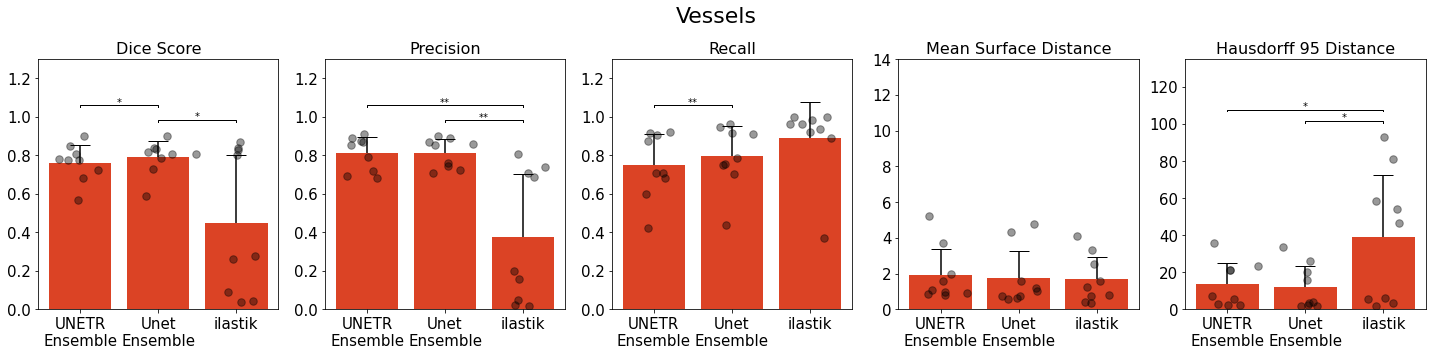

In [32]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
labels = ['UNETR\nEnsemble', 'Unet\nEnsemble', 'ilastik']
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]

data = [np.mean(x['Dice']) for x in data_frames]
data_sd = [np.std(x['Dice']) for x in data_frames]
#data_sd = np.array([np.zeros(len(data_sd)),data_sd])
axs[0].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[0].set_title('Dice Score', fontsize=16)
df_dice = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Dice']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_dice[labels[i]] = y
    axs[0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j],alternative='two-sided',method='exact').pvalue)
#print(pvals_dice)
#pvals_dice = multipletests(pvals_dice, method = 'hs')[1]
#print(pvals_dice)
res_dice_signif_comb = []
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif_comb.append(res[idx])
        res_dice_signif.append(val)
y_range=0.5
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'UNETR\nSingle' not in x]
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_dice_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]
    # What level is this bar among the bars above the plot?
    level = len(res_dice_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top + 0.01
    bar_tips = bar_height - (y_range * 0.02)
    axs[0].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_dice_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.2 * 0.01)
    axs[0].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[0].set_ylim(0,1.3)
    
data = [np.mean(x['Precision']) for x in data_frames]
data_sd = [np.std(x['Precision']) for x in data_frames]
axs[1].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[1].set_title('Precision', fontsize=16)
df_precision = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Precision']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.15, size=len(y))
    df_precision[labels[i]] = y
    axs[1].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_precision = []
for i,j in res:
    pvals_precision.append(stats.wilcoxon(df_precision[i], df_precision[j],alternative='two-sided',method='exact').pvalue)
#pvals_precision = multipletests(pvals_precision, method = 'bonferroni')[1]
res_precision_signif_comb = []
res_precision_signif = []
for idx, val in enumerate(pvals_precision):
    if val < 0.05:
        res_precision_signif_comb.append(res[idx])
        res_precision_signif.append(val)
y_range=0.5
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'UNETR\nSingle' not in x]
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_precision_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_precision_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[1].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_precision_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.4 * 0.01)
    axs[1].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[1].set_ylim(0,1.3)

data = [np.mean(x['Recall']) for x in data_frames]
data_sd = [np.std(x['Recall']) for x in data_frames]
axs[2].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[2].set_title('Recall', fontsize=16)
df_recall = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Recall']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_recall[labels[i]] = y
    axs[2].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_recall = []
for i,j in res:
    pvals_recall.append(stats.wilcoxon(df_recall[i], df_recall[j],alternative='two-sided',method='exact').pvalue)
#pvals_recall = multipletests(pvals_recall, method = 'bonferroni')[1]
res_recall_signif_comb = []
res_recall_signif = []
for idx, val in enumerate(pvals_recall):
    if val < 0.05:
        res_recall_signif_comb.append(res[idx])
        res_recall_signif.append(val)
y_range=0.5
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'UNETR\nSingle' not in x]
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_recall_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_recall_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[2].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_recall_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (1.2 * 0.01)
    axs[2].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[2].set_ylim(0,1.3)

    
data = [np.mean(x['meanSurfaceDistance']) for x in data_frames]
data_sd = [np.std(x['meanSurfaceDistance']) for x in data_frames]
axs[3].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[3].set_title('Mean Surface Distance', fontsize=16)
df_msd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['meanSurfaceDistance']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_msd[labels[i]] = y
    axs[3].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_msd = []
for i,j in res:
    pvals_msd.append(stats.wilcoxon(df_msd[i], df_msd[j],alternative='two-sided',method='exact').pvalue)
#pvals_msd = multipletests(pvals_msd, method = 'bonferroni')[1]
res_msd_signif_comb = []
res_msd_signif = []
for idx, val in enumerate(pvals_msd):
    if val < 0.05:
        res_msd_signif_comb.append(res[idx])
        res_msd_signif.append(val)
y_range=0.5
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'UNETR\nSingle' not in x]
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_msd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_msd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[3].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_msd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (8 * 0.01)
    axs[3].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[3].set_ylim(0,14)


#data = [np.mean(x['Hausdorff']) for x in data_frames]
#data_sd = [np.std(x['Hausdorff']) for x in data_frames]
#axs[1,0].bar(labels,data,yerr=data_sd)
#axs[1,0].set_title('Hausdorff Distance')
#for i, df in enumerate(data_frames):
#    y = df['Hausdorff']
#    x = np.random.normal(i, 0.13, size=len(y))
#    axs[1,0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
#axs[1,0].set_ylim(0,200)

data = [np.mean(x['Hausdorff95']) for x in data_frames]
data_sd = [np.std(x['Hausdorff95']) for x in data_frames]
axs[4].bar(labels,data,yerr=data_sd,color='#DB4325',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[4].set_title('Hausdorff 95 Distance', fontsize=16)
df_hd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Hausdorff95']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_hd[labels[i]] = y
    axs[4].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_hd = []
for i,j in res:
    pvals_hd.append(stats.wilcoxon(df_hd[i], df_hd[j],alternative='two-sided',method='exact').pvalue)
#pvals_hd = multipletests(pvals_hd, method = 'bonferroni')[1]
res_hd_signif_comb = []
res_hd_signif = []
for idx, val in enumerate(pvals_hd):
    if val < 0.05:
        res_hd_signif_comb.append(res[idx])
        res_hd_signif.append(val)
y_range=0.5
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'UNETR\nSingle' not in x]
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_hd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_hd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * 100 * level) + top + 3
    bar_tips = bar_height - (y_range * 0.02*100)
    axs[4].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_hd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (120 * 0.01)
    axs[4].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[4].set_ylim(0,135)
for i in range(5):
    axs[i].tick_params(axis='x', labelsize=15)
    axs[i].tick_params(axis='y', labelsize=15)

fig.suptitle('Vessels',fontsize=22)
fig.tight_layout()
fig.savefig('model_eval_vessels.png')

In [18]:
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
for data_frame in data_frames:
    print(data_frame.mean())
    print(data_frame.std())

Dice                    0.763067
Precision               0.810597
Recall                  0.749663
Hausdorff95            13.566886
meanSurfaceDistance     1.900258
dtype: float64
Dice                    0.096480
Precision               0.089459
Recall                  0.172148
Hausdorff95            12.131861
meanSurfaceDistance     1.544835
dtype: float64
Dice                    0.790461
Precision               0.812733
Recall                  0.796693
Hausdorff95            12.115827
meanSurfaceDistance     1.737011
dtype: float64
Dice                    0.087669
Precision               0.076224
Recall                  0.164648
Hausdorff95            12.143726
meanSurfaceDistance     1.622192
dtype: float64
Dice                    0.449273
Precision               0.376803
Recall                  0.892950
Hausdorff95            38.921016
meanSurfaceDistance     1.674862
dtype: float64
Dice                    0.374646
Precision               0.346835
Recall                  0.198366
H

/tmp/ipykernel_3927521/601560446.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.mean())
/tmp/ipykernel_3927521/601560446.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.std())


In [27]:
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
for data_frame in data_frames:
    print(data_frame.mean())
    print(data_frame.std())

Dice                    0.711937
Precision               0.628137
Recall                  0.841482
Hausdorff95            23.654228
meanSurfaceDistance     1.248422
dtype: float64
Dice                    0.062230
Precision               0.110553
Recall                  0.053174
Hausdorff95            19.298793
meanSurfaceDistance     0.569302
dtype: float64
Dice                    0.765639
Precision               0.697952
Recall                  0.860125
Hausdorff95            20.340159
meanSurfaceDistance     2.409479
dtype: float64
Dice                    0.043767
Precision               0.091108
Recall                  0.060709
Hausdorff95            22.670194
meanSurfaceDistance     3.900826
dtype: float64
Dice                    0.487245
Precision               0.434857
Recall                  0.813957
Hausdorff95            40.999737
meanSurfaceDistance     4.449557
dtype: float64
Dice                    0.195810
Precision               0.239478
Recall                  0.252071
H

/tmp/ipykernel_3927521/601560446.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.mean())
/tmp/ipykernel_3927521/601560446.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(data_frame.std())


In [40]:
res

[('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('Unet\nEnsemble', 'ilastik')]

In [52]:
print(np.mean(data_frames[0]))
print(np.std(data_frames[0]))
print(np.mean(data_frames[1]))
print(np.std(data_frames[1]))
print(np.mean(data_frames[2]))
print(np.std(data_frames[2]))

Dice                    0.763067
Precision               0.810597
Recall                  0.749663
Hausdorff95            13.566886
meanSurfaceDistance     1.900258
dtype: float64
Dice                    0.090962
Precision               0.084343
Recall                  0.162302
Hausdorff95            11.438028
meanSurfaceDistance     1.456484
dtype: float64
Dice                    0.790461
Precision               0.812733
Recall                  0.796693
Hausdorff95            12.115827
meanSurfaceDistance     1.737011
dtype: float64
Dice                    0.082655
Precision               0.071865
Recall                  0.155232
Hausdorff95            11.449215
meanSurfaceDistance     1.529417
dtype: float64
Dice                    0.449273
Precision               0.376803
Recall                  0.892950
Hausdorff95            38.921016
meanSurfaceDistance     1.674862
dtype: float64
Dice                    0.353220
Precision               0.326999
Recall                  0.187021
H

/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Image,Dice,Precision,Recall,Hausdorff95,meanSurfaceDistance
0,XYZres013_0001,0.789158,0.899734,0.702787,3.316625,1.045425
1,XYZres95_0001,0.590400,0.892749,0.441034,33.541020,4.770031
2,XYZres032,0.900587,0.857947,0.947689,2.000000,0.632745
3,XYZres025,0.807703,0.870910,0.753049,2.236068,0.765610
4,XYZres114_0001,0.818571,0.851970,0.787691,20.047442,1.603041
5,XYZres008,0.838657,0.743491,0.961763,4.000000,0.752342
6,XYZres115,0.728616,0.708959,0.749393,26.248809,4.303545
7,XYZres204_0001,0.807481,0.726471,0.908827,15.652476,1.170527
8,XYZres214_0001,0.832978,0.762370,0.918000,2.000000,0.589837


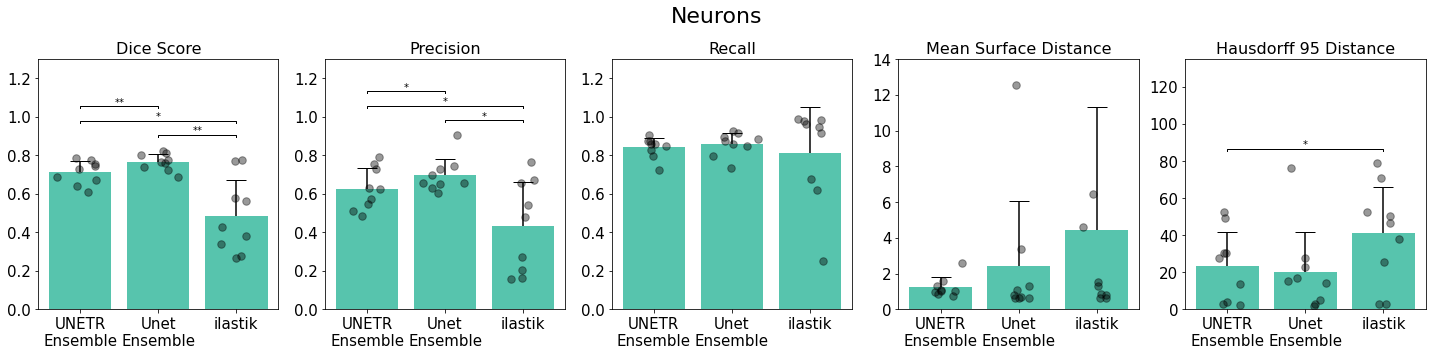

In [62]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
data_frames = [unetrEnsemble, unetEnsemble, ilastik]
labels = ['UNETR\nEnsemble', 'Unet\nEnsemble', 'ilastik']
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]

data = [np.mean(x['Dice']) for x in data_frames]
data_sd = [np.std(x['Dice']) for x in data_frames]
#data_sd = np.array([np.zeros(len(data_sd)),data_sd])
axs[0].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[0].set_title('Dice Score', fontsize=16)
df_dice = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Dice']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_dice[labels[i]] = y
    axs[0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j],alternative='two-sided',method='exact').pvalue)
#print(pvals_dice)
#pvals_dice = multipletests(pvals_dice, method = 'hs')[1]
#print(pvals_dice)
res_dice_signif_comb = []
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif_comb.append(res[idx])
        res_dice_signif.append(val)
y_range=0.5
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'UNETR\nSingle' not in x]
res_dice_signif_comb = [x for x in res_dice_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_dice_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_dice_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top + 0.01
    bar_tips = bar_height - (y_range * 0.02)
    axs[0].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_dice_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[0].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[0].set_ylim(0,1.3)
    
data = [np.mean(x['Precision']) for x in data_frames]
data_sd = [np.std(x['Precision']) for x in data_frames]
axs[1].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[1].set_title('Precision', fontsize=16)
df_precision = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Precision']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.15, size=len(y))
    df_precision[labels[i]] = y
    axs[1].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_precision = []
for i,j in res:
    pvals_precision.append(stats.wilcoxon(df_precision[i], df_precision[j],alternative='two-sided',method='exact').pvalue)
#pvals_precision = multipletests(pvals_precision, method = 'bonferroni')[1]
res_precision_signif_comb = []
res_precision_signif = []
for idx, val in enumerate(pvals_precision):
    if val < 0.05:
        res_precision_signif_comb.append(res[idx])
        res_precision_signif.append(val)
y_range=0.5
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'UNETR\nSingle' not in x]
res_precision_signif_comb = [x for x in res_precision_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_precision_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_precision_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[1].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_precision_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[1].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[1].set_ylim(0,1.3)

data = [np.mean(x['Recall']) for x in data_frames]
data_sd = [np.std(x['Recall']) for x in data_frames]
axs[2].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[2].set_title('Recall', fontsize=16)
df_recall = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Recall']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_recall[labels[i]] = y
    axs[2].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_recall = []
for i,j in res:
    pvals_recall.append(stats.wilcoxon(df_recall[i], df_recall[j],alternative='two-sided',method='exact').pvalue)
#pvals_recall = multipletests(pvals_recall, method = 'bonferroni')[1]
res_recall_signif_comb = []
res_recall_signif = []
for idx, val in enumerate(pvals_recall):
    if val < 0.05:
        res_recall_signif_comb.append(res[idx])
        res_recall_signif.append(val)
y_range=0.5
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'UNETR\nSingle' not in x]
res_recall_signif_comb = [x for x in res_recall_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_recall_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_recall_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[2].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_recall_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[2].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[2].set_ylim(0,1.3)
for i in range(5):
    axs[i].tick_params(axis='x', labelsize=15)
    axs[i].tick_params(axis='y', labelsize=15)
    
data = [np.mean(x['meanSurfaceDistance']) for x in data_frames]
data_sd = [np.std(x['meanSurfaceDistance']) for x in data_frames]
axs[3].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[3].set_title('Mean Surface Distance', fontsize=16)
df_msd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['meanSurfaceDistance']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_msd[labels[i]] = y
    axs[3].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_msd = []
for i,j in res:
    pvals_msd.append(stats.wilcoxon(df_msd[i], df_msd[j],alternative='two-sided',method='exact').pvalue)
#pvals_msd = multipletests(pvals_msd, method = 'bonferroni')[1]
res_msd_signif_comb = []
res_msd_signif = []
for idx, val in enumerate(pvals_msd):
    if val < 0.05:
        res_msd_signif_comb.append(res[idx])
        res_msd_signif.append(val)
y_range=0.5
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'UNETR\nSingle' not in x]
res_msd_signif_comb = [x for x in res_msd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_msd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_msd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axs[3].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_msd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[3].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[3].set_ylim(0,14)


#data = [np.mean(x['Hausdorff']) for x in data_frames]
#data_sd = [np.std(x['Hausdorff']) for x in data_frames]
#axs[1,0].bar(labels,data,yerr=data_sd)
#axs[1,0].set_title('Hausdorff Distance')
#for i, df in enumerate(data_frames):
#    y = df['Hausdorff']
#    x = np.random.normal(i, 0.13, size=len(y))
#    axs[1,0].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
#axs[1,0].set_ylim(0,200)

data = [np.mean(x['Hausdorff95']) for x in data_frames]
data_sd = [np.std(x['Hausdorff95']) for x in data_frames]
axs[4].bar(labels,data,yerr=data_sd,color='#57C4AD',zorder=2,error_kw=dict(capsize = 10, capthick=1,zorder=1))
axs[4].set_title('Hausdorff 95 Distance', fontsize=16)
df_hd = pd.DataFrame(columns = labels)
top = 0
for i, df in enumerate(data_frames):
    y = df['Hausdorff95']
    if np.max(y) > top:
        top=np.max(y)
    x = np.random.normal(i, 0.13, size=len(y))
    df_hd[labels[i]] = y
    axs[4].plot(x, y, '.', alpha=0.4,color='black', markersize=15)
pvals_hd = []
for i,j in res:
    pvals_hd.append(stats.wilcoxon(df_hd[i], df_hd[j],alternative='two-sided',method='exact').pvalue)
#pvals_hd = multipletests(pvals_hd, method = 'bonferroni')[1]
res_hd_signif_comb = []
res_hd_signif = []
for idx, val in enumerate(pvals_hd):
    if val < 0.05:
        res_hd_signif_comb.append(res[idx])
        res_hd_signif.append(val)
y_range=0.5
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'UNETR\nSingle' not in x]
res_hd_signif_comb = [x for x in res_hd_signif_comb if  'Unet\nSingle' not in x]
for i, sig_comb in enumerate(res_hd_signif_comb):
    # Columns corresponding to the datasets of interest
    x1 = np.where(np.array(labels)==sig_comb[0])[0][0]
    x2 = np.where(np.array(labels)==sig_comb[1])[0][0]   
    # What level is this bar among the bars above the plot?
    level = len(res_hd_signif_comb) - i
    # Plot the bar
    bar_height = (y_range * 0.12 * 75 * level) + top + 3
    bar_tips = bar_height - (y_range * 0.02*75)
    axs[4].plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = res_hd_signif[i]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height - (y_range * 0.01)
    axs[4].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
axs[4].set_ylim(0,135)

fig.suptitle('Neurons',fontsize=22)
fig.tight_layout()
fig.savefig('model_eval_neurons.png')

In [63]:
pvals_msd

[0.65234375, 0.49609375, 0.8203125]

In [64]:
pvals_hd

[0.734375, 0.0390625, 0.07421875]

In [61]:
res

[('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('Unet\nEnsemble', 'ilastik')]

In [77]:
df_dice
res = [(a, b) for idx, a in enumerate(labels) for b in labels[idx + 1:]]
pvals_dice = []
for i,j in res:
    pvals_dice.append(stats.wilcoxon(df_dice[i], df_dice[j]).pvalue)
pvals_dice = multipletests(pvals_dice, method = 'bonferroni')[1]
res_dice_signif = []
for idx, val in enumerate(pvals_dice):
    if val < 0.05:
        res_dice_signif.append(res[idx])
res_dice_signif

[('UNETR\nEnsemble', 'Unet\nSingle'),
 ('UNETR\nSingle', 'ilastik'),
 ('Unet\nSingle', 'ilastik')]

In [41]:
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


[('UNETR\nEnsemble', 'UNETR\nSingle'),
 ('UNETR\nEnsemble', 'Unet\nEnsemble'),
 ('UNETR\nEnsemble', 'Unet\nSingle'),
 ('UNETR\nEnsemble', 'ilastik'),
 ('UNETR\nSingle', 'Unet\nEnsemble'),
 ('UNETR\nSingle', 'Unet\nSingle'),
 ('UNETR\nSingle', 'ilastik'),
 ('Unet\nEnsemble', 'Unet\nSingle'),
 ('Unet\nEnsemble', 'ilastik'),
 ('Unet\nSingle', 'ilastik')]

In [57]:
pvals[1]

array([0.078125 , 0.078125 , 0.0390625, 0.1171875, 1.       , 1.       ,
       0.0390625, 1.       , 0.078125 , 0.0390625])